# Домашнее задание: LARS и варианты реализации многоклассовой классификации

## Задание 1: Реализация регрессии с наименьшими углами (LARS)
Регрессия с наименьшими углами (LARS) — это алгоритм регрессии, который выбирает признаки пошагово, что делает его подходящим для задач с большим количеством признаков. Цель — найти подмножество признаков, которые наилучшим образом объясняют целевую переменную.

- LARS начинается с нуля для всех коэффициентов.

- Алгоритм находит признак, наиболее коррелирующий с откликом, и обновляет коэффициент этого признака до его значения по методу наименьших квадратов, пока не будут включены все признаки или не выполнено условие остановки.

Тут можно прочитать подробнее про алгоритм работы https://www.geeksforgeeks.org/least-angle-regression-lars/

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Lars


class LARS:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coefs_ = None
        self.intercept_ = 0 


    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coefs_ = np.zeros(n_features)
        active_set = []
        residuals = y.copy()
        if self.fit_intercept:
            self.mean_X = np.mean(X, axis=0)
            self.mean_y = np.mean(y)
            X = X - self.mean_X
            y = y - self.mean_y
        else:
            self.mean_X = np.zeros(n_features)
            self.mean_y = 0

        while len(active_set) < n_features:
            correlations = X.T @ residuals
            j_max = np.argmax(np.abs(correlations))
            if j_max in active_set:
                break
            active_set.append(j_max)
            X_active = X[:, active_set]
            pseudo_inverse = np.linalg.pinv(X_active)
            coefs_active = pseudo_inverse @ y
            self.coefs_[active_set] = coefs_active
            residuals = y - X @ self.coefs_
            if np.linalg.norm(residuals) < 1e-6:
                break
        if self.fit_intercept:
            self.intercept_ = self.mean_y - np.dot(self.mean_X, self.coefs_)
        assert self.coefs_.shape == (n_features,)


    def predict(self, X):
        return X @ self.coefs_ + self.intercept_

X_train = np.array([[1], [2], [3], [4], [5]])
y_train = np.array([2, 3, 5, 7, 11])
model = LARS()
model.fit(X_train, y_train)
preds = model.predict(X_train)

In [7]:
assert preds.shape == (5,)
assert r2_score(y_train, preds) > 0.8

In [8]:
sklearn_model = Lars()
sklearn_model.fit(X_train, y_train)
sklearn_preds = sklearn_model.predict(X_train)

assert np.allclose(preds, sklearn_preds, rtol=1e-03)

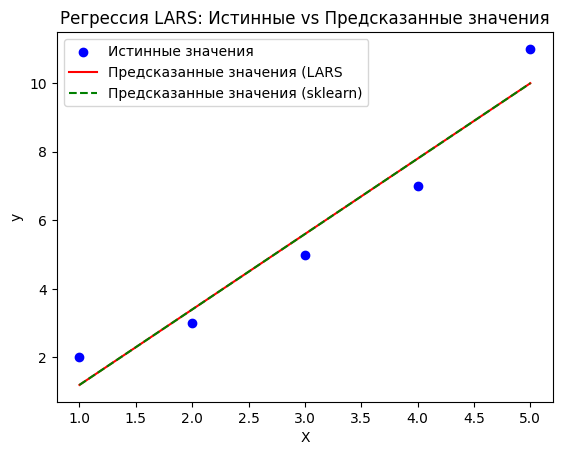

In [9]:
plt.scatter(X_train, y_train, color='blue', label="Истинные значения")
plt.plot(X_train, preds, color='red', label="Предсказанные значения (LARS")
plt.plot(X_train, sklearn_preds, color='green', linestyle='dashed', label="Предсказанные значения (sklearn)")
plt.legend()
plt.title("Регрессия LARS: Истинные vs Предсказанные значения")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Задание 2: Классификация Один-против-Всех и Все-против-Всех с логистической регрессией
В многоклассовой классификации два популярных подхода:

- Один-против-Всех (OvA): Для каждого класса обучается отдельный классификатор, который отделяет этот класс от всех остальных.
- Все-против-Всех (AvA): Обучается классификатор для каждой пары классов.

https://education.yandex.ru/handbook/ml/article/linear-models#:~:text=%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F-,%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F,-%D0%92%20%D1%8D%D1%82%D0%BE%D0%BC%20%D1%80%D0%B0%D0%B7%D0%B4%D0%B5%D0%BB%D0%B5

In [12]:
def plot_ova_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')

    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("One-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    plt.show()


def plot_ava_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')

    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("All-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    plt.show()

In [14]:
!pip3 install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 1.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

class OneVsAllClassifier:
    def __init__(self):
        self.models = []


    def fit(self, X, y):
        n_classes = len(set(y))
        self.models = []
        for c in range(n_classes):
            y_binary = (y == c).astype(int)  #
            model = LogisticRegression()
            model.fit(X, y_binary)
            self.models.append(model)


    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict_proba(X)[:, 1]  
        return np.argmax(predictions, axis=1)


X_test = np.array([[1, 2], [4, 5], [7, 8], [2, 3], [5, 6]])
y_test = np.array([0, 1, 2, 0, 1])
ova_classifier = OneVsAllClassifier()
ova_classifier.fit(X_test, y_test)
ova_preds = ova_classifier.predict(X_test)

assert len(ova_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ova_preds) > 0.8, "Точность должна быть выше 0.8"

/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions

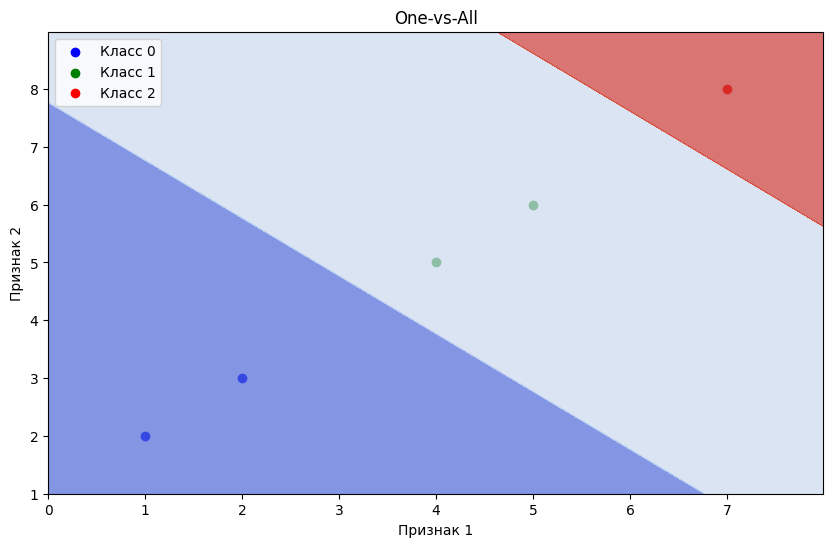

In [16]:
plot_ova_classifier(ova_classifier, X_test, y_test)

In [18]:
from itertools import combinations
from collections import defaultdict

class AllVsAllClassifier:
    def __init__(self):
        self.pairwise_models = {}  


    def fit(self, X, y):
        unique_classes = np.unique(y)
        self.pairwise_models = {}
        for class1, class2 in combinations(unique_classes, 2):
            mask = (y == class1) | (y == class2)
            X_pair = X[mask]
            y_pair = y[mask]
            y_pair_binary = (y_pair == class2).astype(int)
            model = LogisticRegression()
            model.fit(X_pair, y_pair_binary)
            self.pairwise_models[(class1, class2)] = model


    def predict(self, X):
        votes = defaultdict(lambda: np.zeros(X.shape[0]))
        for (class1, class2), model in self.pairwise_models.items():
            pred = model.predict(X) 
            for i in range(X.shape[0]):
                votes[class1][i] += (pred[i] == 0)
                votes[class2][i] += (pred[i] == 1) 
        final_predictions = np.array([max(votes, key=lambda c: votes[c][i]) for i in range(X.shape[0])])
        return final_predictions


ava_classifier = AllVsAllClassifier()
ava_classifier.fit(X_test, y_test)
ava_preds = ava_classifier.predict(X_test)
assert len(ava_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ava_preds) > 0.8, "Точность должна быть выше 0.8"

/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mikhail/.pyenv/versions

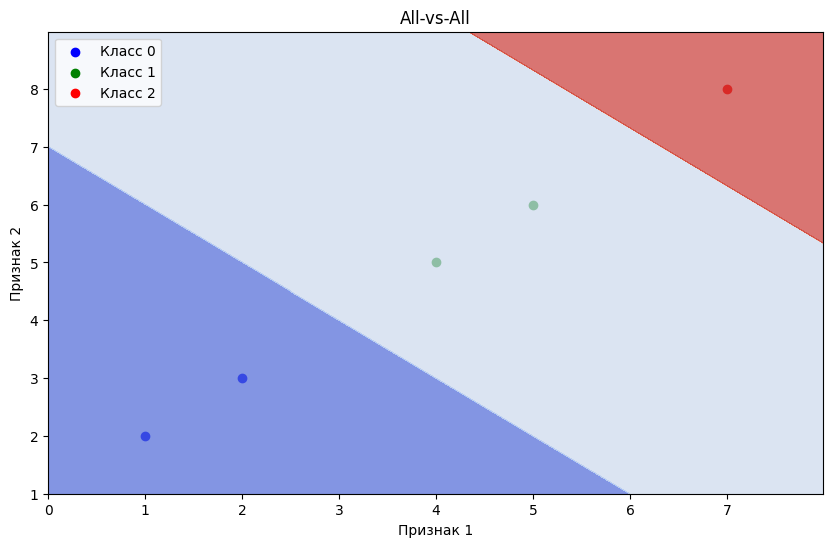

In [19]:
plot_ava_classifier(ava_classifier, X_test, y_test)